In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [160]:
stockdt = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', header=[0,1], index_col=0, parse_dates=True)

In [161]:
stockdt

Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
Date,,,,,
2000-01-03,58.507248,58.507248,56.426713,56.710420,10823694
2000-01-04,56.521252,57.750660,55.922309,57.498474,8606279
2000-01-05,58.507248,60.398648,56.552807,56.962607,13318927
2000-01-06,57.498493,59.988832,57.246307,59.515983,8338607
2000-01-07,57.246300,59.484451,55.796228,59.137696,12402108
...,...,...,...,...,...
2025-04-24,229.330002,232.779999,224.440002,231.179993,15428100
2025-04-25,232.410004,233.360001,226.320007,228.949997,6700100


# Smooth Data

In [162]:
alpha = 0.2
stockdt['Smooth'] = stockdt['Close'].ewm(alpha=alpha, adjust=False).mean()

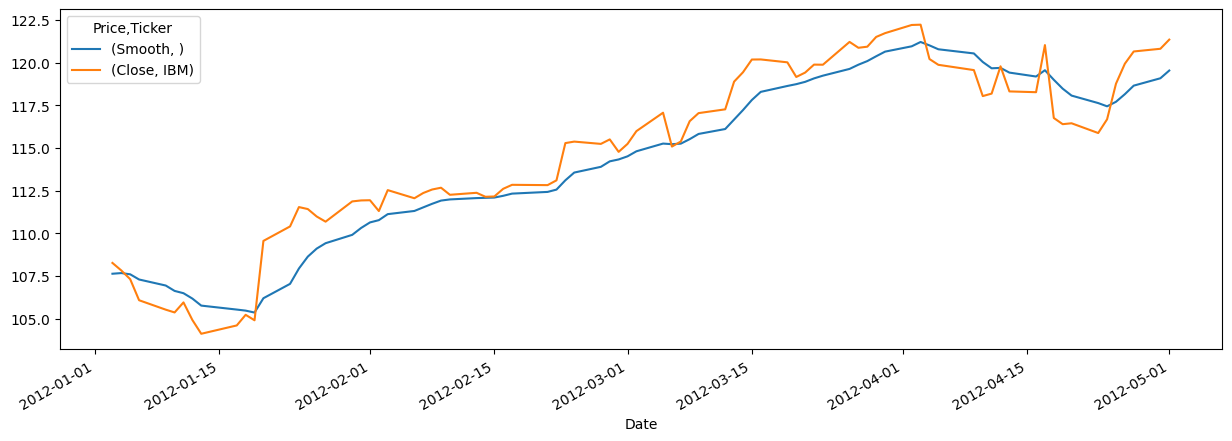

In [166]:
plt.figure(figsize=(15,5))
stockdt.loc["2012-01-01":"2012-05-01", ['Smooth']].plot(ax=plt.gca())
stockdt.loc["2012-01-01":"2012-05-01", ['Close']].plot(ax=plt.gca())
plt.show()

# Technical Indicators

## 1. Momentum Features

### 1.1 RELATIVE STRENGTH INDEX (RSI)

It evaluates the conditions of overbought and oversold in the stock prices by measuring the extent of recent changes in prices. The RSI compares stock’s average gains and losses over a specific period of time, typically 14 trading days. RSI ranges between 0 and 100, and traditionally, RSI above 70 indicates that the stock is overbought, while RSI below 30 indicates that the stock is oversold.

$RSI = 100 - \dfrac{100}{1+RS}$ 

$RS = \frac{AverageGain}{AverageLoss}$


In [18]:
def RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.ewm(com=period, adjust=False).mean()
    avg_loss = loss.ewm(com=period, adjust=False).mean()
    
    rs = avg_gain/avg_loss
    rsi = 100 - (100 / (1+rs))
    
    return rsi

### 1.2 MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)

The moving average convergence divergence (MACD) is defined to be a trend-following momentum indicator that helps investors understand whether the bearish or bullish movement in prices is becoming stronger or weaker.

It is computed by subtracting the 26-day exponential moving average which is the longer moving average from the 12-day exponential moving average of a security’s prices which is defined to be the shorter one. The line obtained from this calculation called the MACD line and the 9-day exponential moving average of the MACD line called the signal line which can work as an incitement for buy and sell signals. However, MACD indicates a buy signal whenever it is above the signal line and a sell signal whenever it is below the signal line.

The formula for calculating MACD is as follows:

$MACD = EMA_{12}(C) - EMA_{26}(C)$

$SL = EMA_9(MACD)$

- MACD stands for moving average convergence divergence or MACD line
    - It measures momentum — how fast prices are changing.
    - If MACD > 0 → upward momentum; if MACD < 0 → downward momentum.
- SL stands for the signal line (usually 9-day EMA of MACD).
    - Acts as a trigger line.
    - When MACD crosses above it → bullish signal.
    - When MACD crosses below it → bearish signal.

- $EMA_n$= n-day exponential moving average
    - $EMA_t = \alpha.P_t + (1-\alpha).EMA_{t-1}$
    - EMA(12) is faster: it reacts quickly to recent price changes.
    - EMA(26) is slower: it smooths out short-term noise.
    - If EMA(12) > EMA(26), prices are moving up faster recently → positive momentum.
    - If EMA(12) < EMA(26), prices are moving down faster recently → negative momentum.

- C = closing price

In [19]:
def MACD(series):
    ema_12 = series.ewm(span=12, adjust=False).mean()
    ema_26 = series.ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

### 1.3 PRICE RATE OF CHANGE (ROC)

The price rate of change (ROC) is another momentum oscillator that compares and cal- culates the percent change in price between the current price and the price n-periods ago. In other words, ROC measures the changes between the current price with respect to the earlier closing price in n days ago. It moves from positive to negative, and fluctuates above and below the zero-line. However, this oscillator can be used for determining the overbought and oversold conditions, divergences and also zero-line crossovers. 
- ROC tells you how much the price has increased or decreased in % over the past n periods.
- It's a simple way to measure momentum — how strong the trend is.

The formula for calculating ROC is as follows:

$ROC = \dfrac{C_t - C_{t-n}}{C_{t-n}} .100$

- ROC stands for price rate of change at time t
- $C_t$ = closing price at time t
- $C_{t-n}$ = closing price n periods ago

In [20]:
def ROC(series, period=14):
    return (series - series.shift(period)) * 100 / series.shift(period)

### 1.4 STOCHASTIC OSCILLATOR (%K)

The stochastic oscillator which is often denoted by the symbol (%K), is a momentum oscillator that was developed by George Lane. The stochastic oscillator identifies the location of the stock’s closing price relative to the High and Low range of the stock’s price over a period of time, typically being 14 trading days. The stochastic oscillator varies from 0 to 100, a reading above 80 generally represents overbought while below 20 represents oversold. We use a 14-day time-frame %K. 

The formula for calculating the stochastic oscillator is given below:

$\% K = \dfrac{C_t - L_{14}}{H_{14} - L_{14}} \times 100$

- $C_t$ = the current closing price.
- $L_{14}$ = lowest Low over the past 14 days 
- $H_{14}$ = highest High in the last 14 days

This formula yields a value between 0 and 100, indicating the closing price's position within the recent trading range. A higher %K value suggests the price is closing near its High, indicating upward momentum, while a lower %K value indicates the price is closing near its Low, suggesting downward momentum.

In [21]:
def STO_OS(Close, Low, High, period=14):
    low_14 = Low.rolling(period).min()
    high_14 = High.rolling(period).max()
    return (Close - low_14) * 100 / (high_14 - low_14)

### 1.5 COMMODITY CHANNEL INDEX (CCI)

The Commodity Channel Index (CCI) was developed by Donald Lambert, it is a useful oscillator that is used to estimate the direction and the strength of the stock price trend. This indicator is also used to determine when stock prices reach the condition of either overbought and oversold. The CCI is calculated by first determining the difference between the mean price of a stock and the average of the means, then comparing this difference to the average difference over a period of time, typically 20 days. The CCI is often scaled by an inverse factor of 0.015. 

The formula used to calculate the CCI is:

$CCI = \dfrac{TypicalPrice - SMA(TP)}{0.015 \times MeanDeviation}$

- Typical Price (TP) = (High + Low + Close) /3
- SMA(TP) = Simple Moving Average of TP over n periods (usually 20)
- Mean Deviation = Average of |TP - SMA| over n periods
- 0.015 is a constant that makes ~70-80% of CCI values fall between -100 and +100

In [22]:
def CCI(Close, Low, High, period=20):
    tp = (High + Low + Close) / 3
    sma_tp = tp.rolling(window=period).mean()
    mean_dev = tp.rolling(window=period).apply(lambda x: (abs(x - x.mean())).mean())
    
    cci = (tp - sma_tp) / (0.015 * mean_dev)
    return cci

### 1.6 DISPARITY INDEX (DIX)
The Disparity Index (DIX) is another useful indicator that is used commonly in technical analysis. This indicator was developed by Steve Nison and it is a momentum indicator that compares the stock’s current price with its moving average (MA) over a particular time period. DIX below 0 indicates that the stock’s current price is below the n-day MA, DIX above 0 indicates that the stock’s current price is above the n-day MA, whereas in the case the DIX equals 0 indicates that the stock’s current price is equal to the n-day MA. 

The formula for calculating the DIX is as follows:

$DIX = \dfrac{C_t - MA_{n}}{MA_{n}} \times 100$
- $C_t$ = current stock price.
- $MA_n$ = moving average over n days

Interpretation:
- Positive DIX (> 0): Price is above its moving average → up-momentum, possibly overbought if High enough.
- Negative DIX (< 0): Price is below its moving average → down-momentum, possibly oversold if Low enough.
- “Zero line” crossovers:
    - Cross ↑ 0 → potential bullish signal
    - Cross ↓ 0 → potential bearish signal

Traders often watch for extreme readings—e.g., +10% or –10%—as overbought/oversold thresholds, though these will vary by asset and timeframe. 

In [23]:
def DIX(Close, period=14, method='SMA'):
    if method.upper() == 'SMA':
        ma = Close.rolling(window=period).mean()
    elif method.upper() == 'EMA':
        ma = Close.ewm(span=period, adjust=False).mean()
    else:
        raise ValueError('Method must be SMA or EMA')
    
    dix = (Close - ma) * 100 / ma
    return dix

## 2. Volatility features

### 2.1 AVERAGE TRUE RANGE (ATR)

ATR quantifies the average range of price fluctuations for an asset over a set number of periods, typically 14. It's particularly useful for identifying periods of High and Low volatility, aiding traders in making informed decisions about entry and exit points.
- High ATR Values: Indicate increased volatility, suggesting larger price movements.
- Low ATR Values: Reflect decreased volatility, implying smaller price movements.
- Non-Directional Indicator: ATR measures the magnitude of price movements without indicating direction.

The formula for calculating ATR:

$TR_t = max(High_t - Low_t, \; |High_t - Close_{t-1}|, \; |Low_t - Close_{t-1})$

$ATR_t = \frac{1}{n}\sum_{i=0}^{n-1}TR_i$

OR

$ATR_t = \alpha.TR_t + (1-\alpha).ATR_{t-1} $

In [24]:
def ATR(Close, Low, High, period=14):
    prev_close = Close.shift(1)
    tr1 = High - Low
    tr2 = (High - prev_close).abs()
    tr3 = (Low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    atr = tr.ewm(span=period, adjust=False).mean()

    return atr

## 3. Volume-based features

### 3.1 ON-BALANCE VOLUME (OBV)

On-Balance Volume (OBV) is a technical indicator used in trading to measure the flow of volume in relation to the price movement of an asset, typically a stock. It helps traders to identify potential buying and selling pressure based on volume changes, which can give insights into the strength or weakness of a price trend.

The core idea behind OBV is that volume precedes price movement, meaning that large volume changes often happen before significant price changes, and this can be a signal for future price movements.

$$
\text{OBV}_{\text{today}} = \text{OBV}_{\text{previous}} +
\begin{cases}
\text{Volume}_{\text{today}}, & \text{if } \text{Close}_{\text{today}} > \text{Close}_{\text{previous}} \\
-\text{Volume}_{\text{today}}, & \text{if } \text{Close}_{\text{today}} < \text{Close}_{\text{previous}} \\
0, & \text{if } \text{Close}_{\text{today}} = \text{Close}_{\text{previous}}
\end{cases}
$$


In [25]:
def OBV(Close, volume):
    price_change_sign = np.sign(Close.diff().fillna(0))
    signed_volume = volume * price_change_sign
    obv = signed_volume.cumsum()
    obv.name = 'OBV'
    return obv

### 3.2 CHAIKIN MONEY FLOW (CMF)
Chaikin Money Flow (CMF) is a technical analysis indicator that measures the buying and selling pressure over a given period. It uses both price and volume to show how much money is flowing into or out of a security.

CMF ranges between -1 and +1:
- Positive values (above 0) suggest accumulation (buying pressure).
- Negative values (below 0) suggest distribution (selling pressure).

To calculate CMF over a period $n$ (usually 20 days):

$$
\text{CMF}_n = \frac{\sum_{i=1}^{n} (\text{Money Flow Multiplier}_i \times \text{Volume}_i)}{\sum_{i=1}^{n} \text{Volume}_i}
$$

**Step-by-step:**

1.  **Money Flow Multiplier (MFM):**
    $$
    \text{MFM}_i = \frac{(\text{Close}_i - \text{Low}_i) - (\text{High}_i - \text{Close}_i)}{\text{High}_i - \text{Low}_i} = \frac{2 \cdot \text{Close}_i - \text{High}_i - \text{Low}_i}{\text{High}_i - \text{Low}_i}
    $$

2.  **Money Flow Volume (MFV):**
    $$
    \text{MFV}_i = \text{MFM}_i \times \text{Volume}_i
    $$

3.  **CMF over $n$ periods:**
    $$
    \text{CMF}_n = \frac{\sum_{i=1}^{n} \text{MFV}_i}{\sum_{i=1}^{n} \text{Volume}_i}
    $$

In [26]:
def CMF(Close, Low, High, volume, period=20):
    mfm = ((2 * Close - High - Low) / (High - Low)).fillna(0)  
    mfv = mfm * volume 

    cmf = mfv.rolling(window=period).sum() / volume.rolling(window=period).sum()
    return cmf

# Feature Engineering

In [126]:
stockdt['RSI'] = RSI(stockdt['Close'])
stockdt['MACD'] = MACD(stockdt['Close'])[0]
stockdt['ROC'] = ROC(stockdt['Close'])
stockdt['%K'] = STO_OS(stockdt['Close'], stockdt['Low'], stockdt['High'])
stockdt['CCI'] = CCI(stockdt['Close'], stockdt['Low'], stockdt['High'])
stockdt['DIX'] = DIX(stockdt['Close'])

stockdt['ATR'] = ATR(stockdt['Close'], stockdt['Low'], stockdt['High'])

stockdt['OBV'] = OBV(stockdt['Close'], stockdt['Volume'])
stockdt['CMF'] = CMF(stockdt['Close'], stockdt['Low'], stockdt['High'], stockdt['Volume'])

stockdt.dropna(axis=0, inplace=True)

<Axes: title={'center': 'CMF'}, xlabel='Date'>

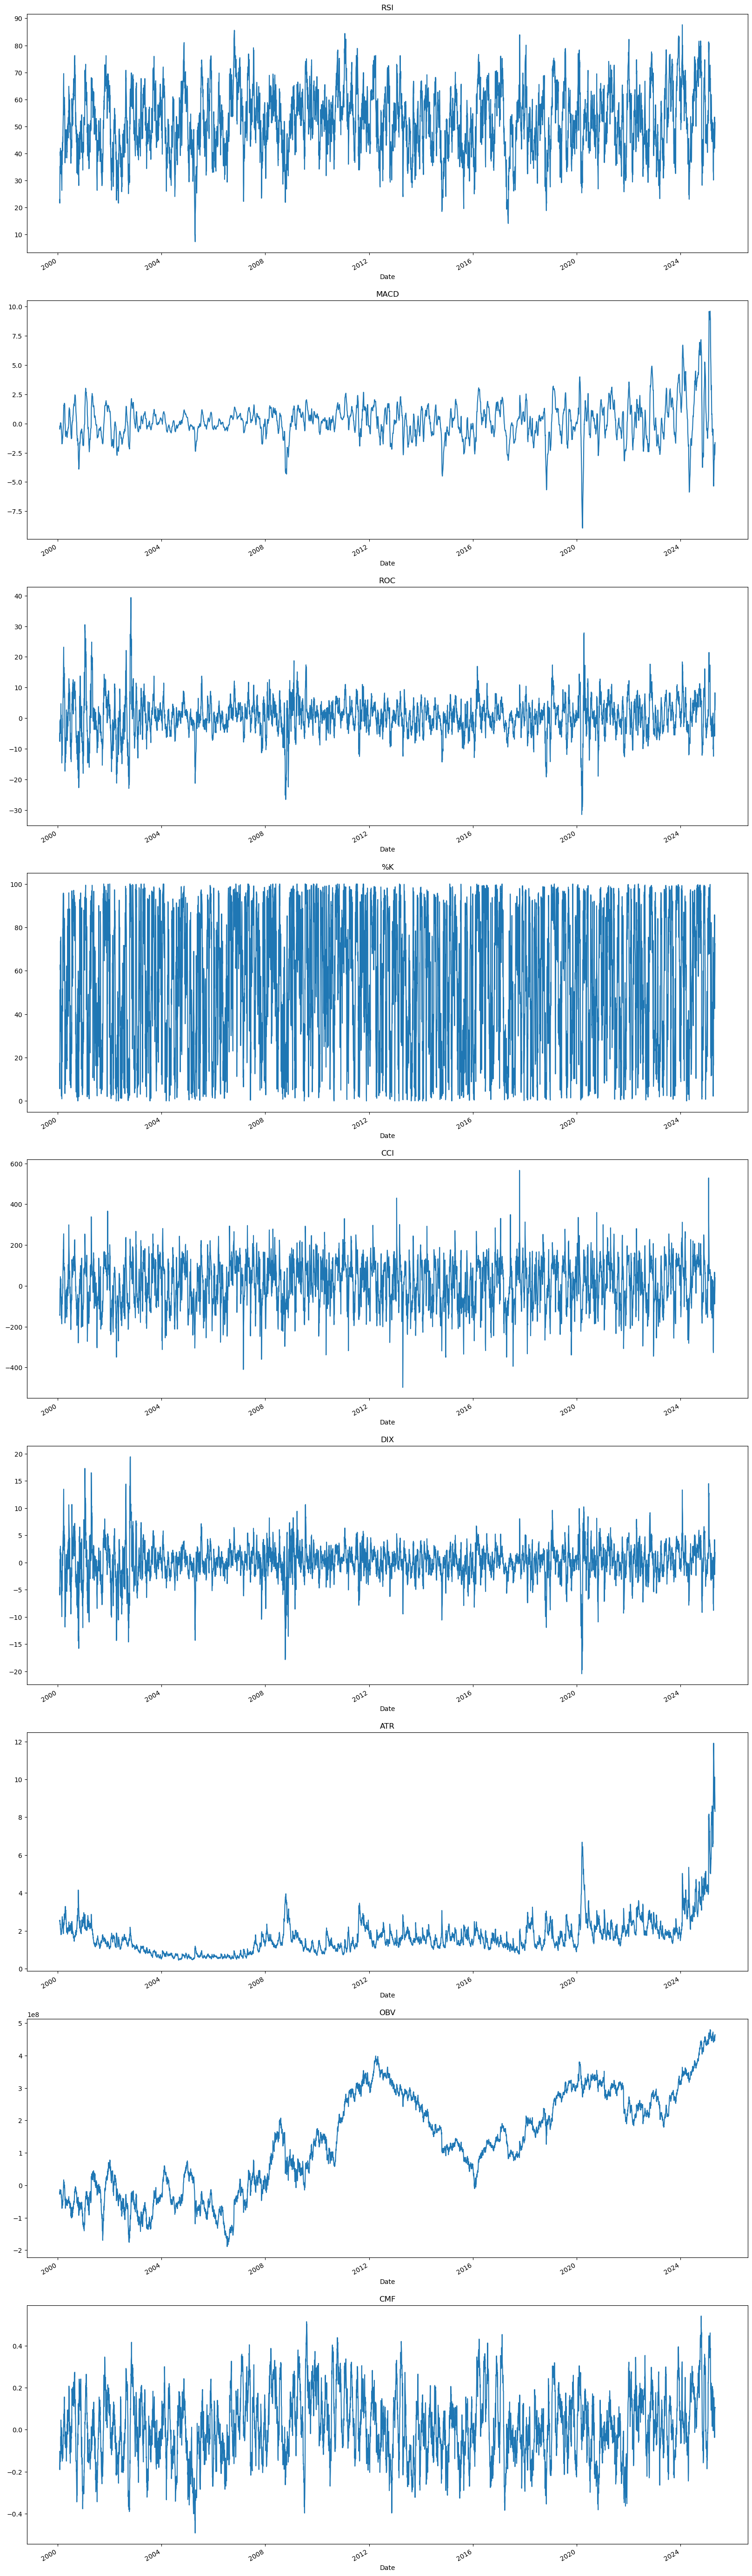

In [127]:
fig = plt.figure(figsize=(20,80))
ax1 = fig.add_subplot(9, 1, 1)
stockdt['RSI'].plot(title='RSI')
fig.add_subplot(9, 1, 2)
stockdt['MACD'].plot(title='MACD')
fig.add_subplot(9, 1, 3)
stockdt['ROC'].plot(title='ROC')
fig.add_subplot(9, 1, 4)
stockdt['%K'].plot(title='%K')
fig.add_subplot(9, 1, 5)
stockdt['CCI'].plot(title='CCI')
fig.add_subplot(9, 1, 6)
stockdt['DIX'].plot(title='DIX')
fig.add_subplot(9, 1, 7)
stockdt['ATR'].plot(title='ATR')
fig.add_subplot(9, 1, 8)
stockdt['OBV'].plot(title='OBV')
fig.add_subplot(9, 1, 9)
stockdt['CMF'].plot(title='CMF')

# Data Lebelling

In [128]:
trading_window = [3, 5, 10, 15, 30, 60, 90]
for window in trading_window:
    stockdt[f'Target_{window}'] = np.sign(stockdt['Smooth'].shift(-window) - stockdt['Smooth'])

In [129]:
stockdt.dropna(axis=0, inplace=True)

In [130]:
stockdt

Price,Close,High,Low,Open,Volume,Smooth,RSI,MACD,ROC,%K,...,ATR,OBV,CMF,Target_3,Target_5,Target_10,Target_15,Target_30,Target_60,Target_90
Ticker,IBM,IBM,IBM,IBM,IBM,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,56.615864,56.899575,55.291885,56.174539,6488024,58.736528,23.020302,-0.227801,-4.872830,17.355386,...,2.546554,-20068659.0,-0.103534,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2000-02-01,55.480988,57.214770,55.039663,56.678872,7640716,58.410974,21.646864,-0.455256,-7.563076,5.599958,...,2.497027,-27709375.0,-0.190652,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
2000-02-02,57.246300,58.412660,55.670135,56.489740,8062254,58.294506,28.733196,-0.487450,-5.020947,27.999966,...,2.554980,-19647121.0,-0.167997,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
2000-02-03,59.074688,59.263826,57.530043,58.002896,6499635,58.372525,35.233391,-0.361265,-0.951376,51.200345,...,2.483320,-13147486.0,-0.146480,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
2000-02-04,58.318104,59.736651,57.908299,59.610558,5653944,58.367083,33.863994,-0.318639,-3.343788,41.600065,...,2.395991,-18801430.0,-0.127123,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11,228.597046,231.457991,227.613607,231.150045,3872700,224.665930,59.117348,4.694836,7.232057,61.669402,...,4.876571,453325414.0,0.317696,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0
2024-12-12,230.722885,232.342103,228.855337,229.133483,4515700,225.271626,61.405972,4.610132,4.433457,61.592603,...,4.725703,457841114.0,0.294774,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


# Train-test split

In [131]:
test_size = 1000
train_idx = stockdt.index[:len(stockdt)-test_size]
test_idx = stockdt.index[len(stockdt)-test_size:]

In [132]:
X = stockdt.loc[:, 'RSI':'CMF']
y = stockdt.loc[:, 'Target_3':]

X_train = X.loc[train_idx, :]
X_test = X.loc[test_idx, :]

y_train = {}
y_test = {}
for window in trading_window:
    y_train[window] = y.loc[train_idx, f'Target_{window}']
    y_test[window] = y.loc[test_idx, f'Target_{window}']


# Tunning hyper-parameter using rolling cross-validation and train data

In [138]:
grid_rf = {
'n_estimators': [100, 200, 300],  
'max_depth': [3, 5, 7, 9, None],  
'max_features': [3, 4, 5]
}

tscv = TimeSeriesSplit(n_splits=5)
models = []
for window in [3]:
    gscv = GridSearchCV(estimator=RandomForestClassifier(random_state=36, n_jobs=-1), param_grid=grid_rf, cv=tscv, scoring='accuracy')
    gscv_fit = gscv.fit(X_train, y_train[window])
    best_parameters = gscv_fit.best_params_
    print("Hyperparameter: ", best_parameters)
    model = RandomForestClassifier(**best_parameters, random_state=36)
    model.fit(X_train, y_train[window])
    models.append(model)

Hyperparameter:  {'max_depth': 3, 'max_features': 4, 'n_estimators': 300}


# Testing

In [285]:
value_counts = pd.Series(y_train[30]).value_counts()

# Get proportion of 1s and -1s
proportion_1 = value_counts.get(1, 0) / len(y_train[30])
proportion_minus_1 = value_counts.get(-1, 0) / len(y_train[30])

print("Proportion of 1s:", proportion_1)
print("Proportion of -1s:", proportion_minus_1)

Proportion of 1s: 0.551296941540844
Proportion of -1s: 0.44870305845915603


In [139]:
y_pred = {}
accuracy = {}
precision = {}
recall = {}
f1 = {}
confusion_mat = {}
for i,window in enumerate([3]):
    y_pred[window] = models[i].predict(X_test)
    accuracy[window] = accuracy_score(y_test[window], y_pred[window])
    precision[window] = precision_score(y_test[window], y_pred[window], average='macro')
    recall[window] = recall_score(y_test[window], y_pred[window], average='macro')
    f1[window] = f1_score(y_test[window], y_pred[window], average='macro')
    confusion_mat[window] = confusion_matrix(y_test[window], y_pred[window])

    print(f"{window}_day Trading Window")
    print("Accuracy:", accuracy[window])
    print("Precision:", precision[window])
    print("Recall:", recall[window])
    print("F1 Score:", f1[window])
    print("Confusion Matrix:")
    print(confusion_mat[window])
    
    print()

3_day Trading Window
Accuracy: 0.849
Precision: 0.8430108016954561
Recall: 0.8438185261479167
F1 Score: 0.8434063170513928
Confusion Matrix:
[[330  74]
 [ 77 519]]



In [43]:
models[0].feature_importances_

array([0.08183307, 0.13443689, 0.06734974, 0.05816529, 0.06440901,
       0.06051878, 0.15186416, 0.26188083, 0.11954224])

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


<Figure size 1500x500 with 0 Axes>

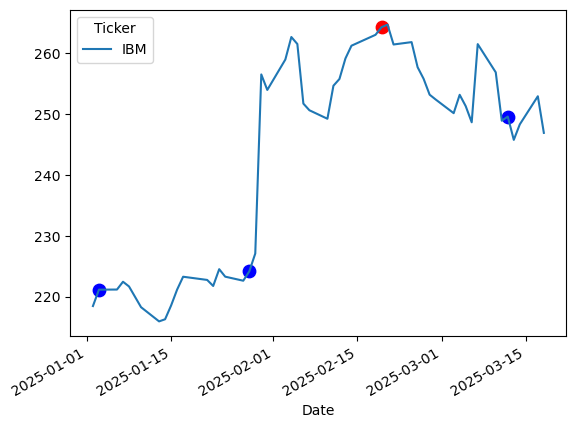

In [115]:
plt.figure(figsize=(15,5))
test = stockdt['2025-01-01':]
test['Close'].plot()

index = 1
buy = []
sell = []
while index < 51:
    if model.predict(X_test.iloc[index:index+1]) == 1:
        buy.append(index)
    else:
        sell.append(index)
    index+=15

plt.scatter(
    [test.index[i] for i in buy],       # x‐coords of buys
    [test.iloc[i]['Close'] for i in buy],     # y‐coords of buys
    marker='o',
    s=80,                           # size of the circles
    facecolors='blue',             # hollow circles; use facecolors='blue' for filled
    edgecolors='blue',
    label='Buy'
)

plt.scatter(
    [test.index[i] for i in sell],       # x‐coords of buys
    [test.iloc[i]['Close'] for i in sell],     # y‐coords of buys
    marker='o',
    s=80,                           # size of the circles
    facecolors='red',             # hollow circles; use facecolors='blue' for filled
    edgecolors='red',
    label='Buy'
)

In [289]:
grid_rf = {
'n_estimators': [100, 200, 300],  
'max_depth': [3, 5, 7, 9],  
'max_features': [3, 4, 5]
}

tscv = TimeSeriesSplit(n_splits=5)
gscv = GridSearchCV(estimator=RandomForestClassifier(random_state=36), param_grid=grid_rf, cv=tscv, scoring='accuracy')
gscv_fit = gscv.fit(X_train, y_train[30])
best_parameters = gscv_fit.best_params_
print("Hyperparameter: ", best_parameters)

model = RandomForestClassifier(**best_parameters, random_state=36)
model.fit(X_train, y_train[30])

Hyperparameter:  {'max_depth': 3, 'max_features': 4, 'n_estimators': 300}


RandomForestClassifier(max_depth=3, max_features=4, n_estimators=300,
                       random_state=36)

In [291]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test[30], y_pred)
precision = precision_score(y_test[30], y_pred, average='macro')
recall = recall_score(y_test[30], y_pred, average='macro')
f1 = f1_score(y_test[30], y_pred, average='macro')
confusion_mat = confusion_matrix(y_test[30], y_pred)

print("TARGET 30 DAYS FROM 2025-01-01 TO 2025-04-30")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

TARGET 30 DAYS FROM 2025-01-01 TO 2025-04-30
Accuracy: 0.4831050228310502
Precision: 0.4635159874347292
Recall: 0.46362143474503026
F1 Score: 0.4635623675719093
Confusion Matrix:
[[160 285]
 [281 369]]


In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

def RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period, adjust=False).mean()
    avg_loss = loss.ewm(com=period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def MACD(series):
    ema_12 = series.ewm(span=12, adjust=False).mean()
    ema_26 = series.ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def ROC(series, period=14):
    return (series - series.shift(period)) * 100 / series.shift(period)

def STO_OS(close, low, high, period=14):
    low_14 = low.rolling(period).min()
    high_14 = high.rolling(period).max()
    return (close - low_14) * 100 / (high_14 - low_14)

def CCI(close, low, high, period=20):
    tp = (high + low + close) / 3
    sma_tp = tp.rolling(window=period).mean()
    mean_dev = tp.rolling(window=period).apply(lambda x: (abs(x - x.mean())).mean())
    cci = (tp - sma_tp) / (0.015 * mean_dev)
    return cci

def DIX(close, period=14, method='SMA'):
    if method.upper() == 'SMA':
        ma = close.rolling(window=period).mean()
    elif method.upper() == 'EMA':
        ma = close.ewm(span=period, adjust=False).mean()
    else:
        raise ValueError('Method must be SMA or EMA')
    dix = (close - ma) * 100 / ma
    return dix

def ATR(close, low, high, period=14):
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(span=period, adjust=False).mean()
    return atr

def OBV(close, volume):
    price_change_sign = np.sign(close.diff().fillna(0))
    signed_volume = volume * price_change_sign
    obv = signed_volume.cumsum()
    obv.name = 'OBV'
    return obv

def CMF(close, low, high, volume, period=20):
    mfm = ((2 * close - high - low) / (high - low)).fillna(0)
    mfv = mfm * volume
    cmf = mfv.rolling(window=period).sum() / volume.rolling(window=period).sum()
    return cmf

def add_features(stockdt):
    # Existing technical indicators
    stockdt['RSI'] = RSI(stockdt['Close'])
    stockdt['MACD'], stockdt['MACD_Signal'] = MACD(stockdt['Close'])
    stockdt['ROC'] = ROC(stockdt['Close'])
    stockdt['%K'] = STO_OS(stockdt['Close'], stockdt['Low'], stockdt['High'])
    stockdt['CCI'] = CCI(stockdt['Close'], stockdt['Low'], stockdt['High'])
    stockdt['DIX'] = DIX(stockdt['Close'])
    stockdt['ATR'] = ATR(stockdt['Close'], stockdt['Low'], stockdt['High'])
    stockdt['OBV'] = OBV(stockdt['Close'], stockdt['Volume'])
    stockdt['CMF'] = CMF(stockdt['Close'], stockdt['Low'], stockdt['High'], stockdt['Volume'])

    # Additional features
    # Lagged returns
    for lag in [1, 3, 5]:
        stockdt[f'Return_Lag{lag}'] = stockdt['Close'].pct_change(lag)
    # Rolling statistics
    for window in [5, 10, 20]:
        stockdt[f'Close_RollMean_{window}'] = stockdt['Close'].rolling(window).mean()
        stockdt[f'Close_RollStd_{window}'] = stockdt['Close'].rolling(window).std()
    # Bollinger Bands
    stockdt['BB_Mid'] = stockdt['Close'].rolling(window=20).mean()
    stockdt['BB_Upper'] = stockdt['BB_Mid'] + 2 * stockdt['Close'].rolling(window=20).std()
    stockdt['BB_Lower'] = stockdt['BB_Mid'] - 2 * stockdt['Close'].rolling(window=20).std()

    stockdt.dropna(axis=0, inplace=True)
    return stockdt

def main():
    # Load data
    stockdt = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', header=[0,1], index_col=0, parse_dates=True)
    stockdt.columns = stockdt.columns.get_level_values(0)  # Flatten MultiIndex

    # Add features
    stockdt = add_features(stockdt)

    # Define target variables
    trading_window = [3, 5, 10, 15, 30, 60, 90]
    for window in trading_window:
        stockdt[f'Target_{window}'] = np.sign(stockdt['Close'].shift(-window) - stockdt['Close'])
    stockdt.dropna(axis=0, inplace=True)

    # Split data
    test_size = 1000
    train_idx = stockdt.index[:len(stockdt) - test_size]
    test_idx = stockdt.index[len(stockdt) - test_size:]

    # Feature columns (exclude target variables)
    feature_cols = [col for col in stockdt.columns if col not in [f'Target_{w}' for w in trading_window]]
    X = stockdt[feature_cols]
    y = stockdt[[f'Target_{w}' for w in trading_window]]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

    X_train = X_scaled.loc[train_idx, :]
    X_test = X_scaled.loc[test_idx, :]
    y_train = {window: y.loc[train_idx, f'Target_{window}'] for window in trading_window}
    y_test = {window: y.loc[test_idx, f'Target_{window}'] for window in trading_window}

    # Check class balance
    for window in trading_window:
        print(f"Class distribution for Target_{window}:")
        print(y_train[window].value_counts(normalize=True))

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10, None],
        'max_features': ['sqrt', 'log2', None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    }

    # Train models for each window
    tscv = TimeSeriesSplit(n_splits=10)
    models = {}
    for window in [30]:
        print(f"\nTraining model for {window}-day window...")
        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=36)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train[window])

        # Randomized search for hyperparameter tuning
        rf = RandomForestClassifier(random_state=36, n_jobs=-1)
        search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_grid,
            n_iter=20,
            cv=tscv,
            scoring='f1_macro',
            random_state=36,
            n_jobs=-1
        )
        search.fit(X_train_smote, y_train_smote)
        best_params = search.best_params_
        print(f"Best parameters for {window}-day window: {best_params}")

        # Train model with best parameters
        model = RandomForestClassifier(**best_params, random_state=36)
        model.fit(X_train_smote, y_train_smote)
        models[window] = model

        # Feature importance
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        print(f"Feature importances for {window}-day window:")
        print(importances.sort_values(ascending=False))

    # Evaluate models
    for window in [30]:
        y_pred = models[window].predict(X_test)
        y_proba = models[window].predict_proba(X_test)[:, 1] if len(np.unique(y_test[window])) > 1 else None

        print(f"\n{window}-day Trading Window")
        print(f"Accuracy: {accuracy_score(y_test[window], y_pred):.4f}")
        print(f"Precision: {precision_score(y_test[window], y_pred, average='macro', zero_division=0):.4f}")
        print(f"Recall: {recall_score(y_test[window], y_pred, average='macro', zero_division=0):.4f}")
        print(f"F1 Score: {f1_score(y_test[window], y_pred, average='macro', zero_division=0):.4f}")
        if y_proba is not None:
            print(f"AUC-ROC: {roc_auc_score(y_test[window], y_proba):.4f}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test[window], y_pred))


main()

Class distribution for Target_3:
Target_3
 1.0    0.520623
-1.0    0.477856
 0.0    0.001521
Name: proportion, dtype: float64
Class distribution for Target_5:
Target_5
 1.0    0.521004
-1.0    0.476906
 0.0    0.002091
Name: proportion, dtype: float64
Class distribution for Target_10:
Target_10
 1.0    0.532598
-1.0    0.466831
 0.0    0.000570
Name: proportion, dtype: float64
Class distribution for Target_15:
Target_15
 1.0    0.550276
-1.0    0.449154
 0.0    0.000570
Name: proportion, dtype: float64
Class distribution for Target_30:
Target_30
 1.0    0.549705
-1.0    0.450295
Name: proportion, dtype: float64
Class distribution for Target_60:
Target_60
 1.0    0.582399
-1.0    0.417601
Name: proportion, dtype: float64
Class distribution for Target_90:
Target_90
 1.0    0.597225
-1.0    0.402775
Name: proportion, dtype: float64

Training model for 30-day window...
Best parameters for 30-day window: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'l

In [ ]:
X

Price,RSI,MACD,ROC,%K,CCI,DIX,ATR,OBV,CMF
Ticker,,,,,,,,,
Date,,,,,,,,,
2000-01-31,23.020302,-0.227801,-4.872830,17.355386,-143.083186,-4.573203,2.546554,-20068659.0,-0.103534
2000-02-01,21.646864,-0.455256,-7.563076,5.599958,-144.497435,-5.972177,2.497027,-27709375.0,-0.190652
2000-02-02,28.733196,-0.487450,-5.020947,27.999966,-88.716218,-2.623636,2.554980,-19647121.0,-0.167997
2000-02-03,35.233391,-0.361265,-0.951376,51.200345,-14.431430,0.555790,2.483320,-13147486.0,-0.146480
2000-02-04,33.863994,-0.318639,-3.343788,41.600065,-14.136929,-0.487954,2.395991,-18801430.0,-0.127123
...,...,...,...,...,...,...,...,...,...
2024-12-11,59.117348,4.694836,7.232057,61.669402,59.543910,0.389819,4.876571,453325414.0,0.317696
2024-12-12,61.405972,4.610132,4.433457,61.592603,66.478237,1.013037,4.725703,457841114.0,0.294774
